In [25]:
# Import the needed libarairies

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm


from sklearn.preprocessing import StandardScaler
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [26]:
movie_mtd = pd.read_table('data/movie_metadata_CMU_IMDB.csv', sep=',')
actor_mtd = pd.read_table('data/actor_metadata_CMU.csv', sep=',')
globes_index = pd.read_csv('data/globes_award_index.csv', sep=',')
oscars_index = pd.read_csv('data/oscars_award_index.csv', sep=',')

In [27]:
# Match the dataframes data

globes_index = globes_index.rename(columns={"nominee":"actor_name"})
oscars_index = oscars_index.rename(columns={"nominee":"actor_name"})

### Create useful features for the creation of the success index

In [28]:
df_actors = actor_mtd[['actor_name', 'birth_date', 'gender', 'height', 'nationality']].drop_duplicates(subset='actor_name').reset_index()

min_age = actor_mtd.groupby('actor_name', as_index=False)['age_at_release'].min()
min_age.rename(columns={'age_at_release': 'age_first_movie'}, inplace=True)
df_actors = df_actors.merge(min_age, on='actor_name', how='left')

max_age = actor_mtd.groupby('actor_name', as_index=False)['age_at_release'].max()
max_age.rename(columns={'age_at_release': 'age_last_movie'}, inplace=True)
df_actors = df_actors.merge(max_age, on='actor_name', how='left')

# Number of movies
count_movies = actor_mtd.groupby('actor_name', as_index=False)['title'].count()
count_movies.rename(columns={'title' : 'number_of_movies'}, inplace=True)
df_actors = df_actors.merge(count_movies, on='actor_name', how='left')

# Career length
df_actors['career_length'] = df_actors['age_last_movie'] - df_actors['age_first_movie']

In [29]:
# Famous movies

# Names of famous movies (top 10% based on box_office)
famous_movie_df = movie_mtd.sort_values('box_office', ascending = False)
len_revenue = int(len(famous_movie_df) * 0.1)
top_10_percent_movies = famous_movie_df.head(len_revenue)
names_fam_movies = top_10_percent_movies['title'].to_list()

# Count famous movies per actor
df_famous = actor_mtd[actor_mtd['title'].isin(names_fam_movies)]
actor_famous_count = df_famous.groupby('actor_name')['title'].nunique().reset_index()

# Merge the information with the original dataframe
all_actors = pd.DataFrame({'actor_name': actor_mtd['actor_name'].unique()})
actor_famous_count_full = pd.merge(all_actors, actor_famous_count, on='actor_name', how='left')
actor_famous_count_full['title'] = actor_famous_count_full['title'].fillna(0).astype(int)
df_actors['numb_fam_movies'] = actor_famous_count_full['title']

## Prepare data for the model: Golden globes ground truth

In [30]:
# Merge the golden globe - based index

df_actors_merged = df_actors.merge(globes_index, on = 'actor_name', how = 'left')
df_actors_merged = df_actors_merged.fillna(0) # We suppose that the actors that are no in the globes_index dataframe have 0 nominees/awards
# Problem here -> the dataset will be umbalanced (a lot of 0s)
df_actors_merged.head()

,index,actor_name,birth_date,gender,height,nationality,age_first_movie,age_last_movie,number_of_movies,career_length,numb_fam_movies,nr_wins,nr_nominations,globes_index
0,0,Wanda De Jesus,1958.0,F,1.620,American,31.0,51.0,8.0,20.0,5,0.0,0.0,0.0
1,1,Natasha Henstridge,1974.0,F,1.780,Other,20.0,35.0,23.0,15.0,7,0.0,0.0,0.0
2,2,Ice Cube,1969.0,M,1.727,American,22.0,42.0,33.0,20.0,20,0.0,0.0,0.0
3,3,Jason Statham,1967.0,M,1.750,Other,30.0,44.0,31.0,14.0,26,0.0,0.0,0.0
4,4,Clea DuVall,1977.0,F,1.650,American,19.0,34.0,31.0,15.0,15,0.0,0.0,0.0


In [31]:
# Prepare data for the regression

features = ['gender','height','age_first_movie','number_of_movies','career_length','numb_fam_movies']

X = df_actors_merged[features]
X = pd.get_dummies(X)
X = X.drop(columns=['gender_0']) # to avoid redundacy (std err, z, P>|z| were all nan)
Y = df_actors_merged['globes_index']

In [32]:
# Split to test and train
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, shuffle = True)

# Standardize data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Convert to DataFrame with aligned indices
X_train = pd.DataFrame(X_train_std, columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_std, columns=X.columns, index=X_test.index)

# Displaying the size of each sets
print(f"The training set has {X_train.shape[0]} samples (and a shape of {X_train.shape}).")
print(f"The test set has {X_test.shape[0]} samples (and a shape of {X_test.shape}).")

print(f"The target variable y for training has the shape {y_train.shape}.")
print(f"The target variable y for testing has the shape {y_test.shape}.")

The training set has 107263 samples (and a shape of (107263, 7)).
The test set has 26816 samples (and a shape of (26816, 7)).
The target variable y for training has the shape (107263,).
The target variable y for testing has the shape (26816,).


In [33]:
from sklearn.utils import shuffle
# Undersampling to balance the dataset

# Combine the training data into a DataFrame
df_train = pd.concat([X_train, y_train], axis=1)

# Separate the majority and minority classes
df_majority = df_train[df_train['globes_index'] == 0.0]
df_class_1 = df_train[df_train['globes_index'] == 1]
df_class_2 = df_train[df_train['globes_index'] == 2]
df_class_3 = df_train[df_train['globes_index'] == 3]

# Oversample the minority class
df_class_1_oversampled = df_class_1.sample(len(df_majority), replace=True, random_state=42)
df_class_2_oversampled = df_class_2.sample(len(df_majority), replace=True, random_state=42)
df_class_3_oversampled = df_class_3.sample(len(df_majority), replace=True, random_state=42)

# Combine the majority and oversampled minority classes
df_balanced = pd.concat([df_majority, df_class_1_oversampled, df_class_2_oversampled, df_class_3_oversampled])

# Separate features and target
X_train = df_balanced.drop('globes_index', axis=1)
y_train = df_balanced['globes_index']

# Shuffle the dataset to ensure random distribution
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [34]:
print(f'Train set: {y_train.value_counts()}')
print(f'Test set: {y_test.value_counts()}')

Train set: globes_index
1.0    105960
3.0    105960
2.0    105960
0.0    105960
Name: count, dtype: int64
Test set: globes_index
0.0    26480
1.0      206
2.0       97
3.0       33
Name: count, dtype: int64


### Ordered regression

In [35]:
# The used indices are ordered (0<1<2<3)

model = OrderedModel(y_train, X_train, distr='logit')  # The model automatically adds a constant
result = model.fit()  # Provide appropriate weights for each class)
print(result.summary())

c:\Users\gerry\anaconda3\envs\ada\Lib\site-packages\statsmodels\base\optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,


                             OrderedModel Results                             
Dep. Variable:           globes_index   Log-Likelihood:            -4.7431e+05
Model:                   OrderedModel   AIC:                         9.486e+05
Method:            Maximum Likelihood   BIC:                         9.487e+05
Date:                Fri, 20 Dec 2024                                         
Time:                        21:30:39                                         
No. Observations:              423840                                         
Df Residuals:                  423830                                         
Df Model:                           7                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
height               0.0146      0.003      5.802      0.000       0.010       0.020
age_first_movie     -0.2183      0

c:\Users\gerry\anaconda3\envs\ada\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
# Predict on test data
y_pred_probs = result.predict(X_test)
y_pred = y_pred_probs.idxmax(axis=1)  # Take the category with the highest probability

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on Test Data: {accuracy:.4f}')

Accuracy on Test Data: 0.9347


### Inference

In [37]:
# Predict on all data

X_new = df_actors[features]

# Pre process in the same way
X_new = pd.get_dummies(X_new)
X_new_std = scaler.transform(X_new)
X_new = pd.DataFrame(X_new_std, columns=X_new.columns, index=X_new.index)
y_pred_probs_new = result.predict(X_new)
y_pred_new = y_pred_probs_new.idxmax(axis=1)

C:\Users\gerry\AppData\Local\Temp\ipykernel_24840\3867136764.py:10: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  y_pred_new = y_pred_probs_new.idxmax(axis=1)


In [38]:
# Add the predictions to the dataframe
df_actors['predicted'] = y_pred_new

# See the average index for American vs. Foreign actors
avg_index = df_actors.groupby('nationality')['predicted'].mean()
print(f'The average success indices are: \n{avg_index}')

The average success indices are: 
nationality
American    0.718827
Other       0.465978
Name: predicted, dtype: float64


In [39]:
# Print descriptive statistics
stats = df_actors.groupby('nationality')['predicted'].describe()
stats

,count,mean,std,min,25%,50%,75%,max
nationality,,,,,,,,
American,6512.0,0.718827,0.940413,0.0,0.0,0.0,1.0,3.0
Other,3483.0,0.465978,0.785918,0.0,0.0,0.0,1.0,3.0


C:\Users\gerry\AppData\Local\Temp\ipykernel_24840\2154095391.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='nationality', y='predicted', data=df_actors, palette = {'American': 'indianred', 'Other': 'mediumseagreen'}, scale='count', inner="quart")
C:\Users\gerry\AppData\Local\Temp\ipykernel_24840\2154095391.py:1: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x='nationality', y='predicted', data=df_actors, palette = {'American': 'indianred', 'Other': 'mediumseagreen'}, scale='count', inner="quart")


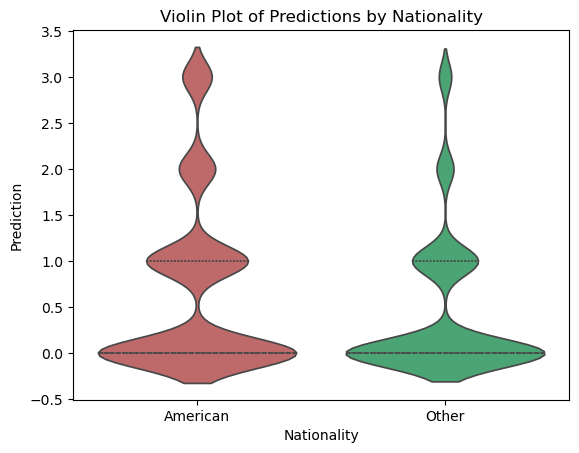

In [40]:
sns.violinplot(x='nationality', y='predicted', data=df_actors, palette = {'American': 'indianred', 'Other': 'mediumseagreen'}, scale='count', inner="quart")

plt.xlabel("Nationality")
plt.ylabel("Prediction")
plt.title("Violin Plot of Predictions by Nationality")
plt.show()

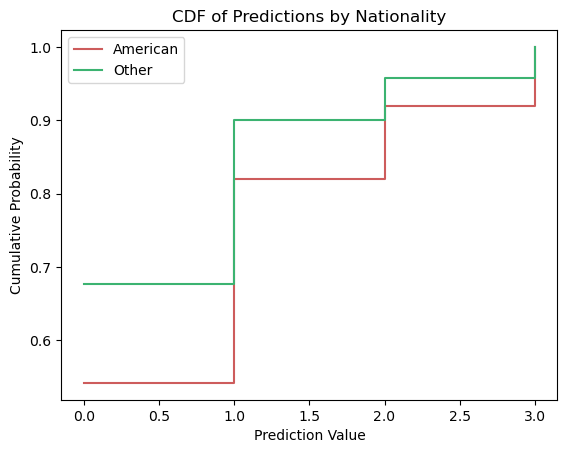

In [41]:
cdf_american = df_actors[df_actors['nationality'] == 'American']['predicted'].value_counts(normalize=True).sort_index().cumsum()
cdf_other = df_actors[df_actors['nationality'] == 'Other']['predicted'].value_counts(normalize=True).sort_index().cumsum()

# Plot CDFs
plt.step(cdf_american.index, cdf_american.values, where='post', label='American', color='indianred')
plt.step(cdf_other.index, cdf_other.values, where='post', label='Other', color='mediumseagreen')

plt.xlabel("Prediction Value")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Predictions by Nationality")
plt.legend()
plt.show()

## Prepare data for the model: Oscars ground truth

In [42]:
# Merge the golden globe - based index

df_actors_merged_oscar = df_actors.merge(oscars_index, on = 'actor_name', how = 'left')
df_actors_merged_oscar = df_actors_merged_oscar.fillna(0) # We suppose that the actors that are no in the globes_index dataframe have 0 nominees/awards
# Problem here -> the dataset will be umbalanced (a lot of 0s)
df_actors_merged_oscar.head()

,index,actor_name,birth_date,gender,height,nationality,age_first_movie,age_last_movie,number_of_movies,career_length,numb_fam_movies,predicted,nr_wins,nr_nominations,oscar_index
0,0,Wanda De Jesus,1958.0,F,1.620,American,31.0,51.0,8.0,20.0,5,1.0,0.0,0.0,0.0
1,1,Natasha Henstridge,1974.0,F,1.780,Other,20.0,35.0,23.0,15.0,7,1.0,0.0,0.0,0.0
2,2,Ice Cube,1969.0,M,1.727,American,22.0,42.0,33.0,20.0,20,2.0,0.0,0.0,0.0
3,3,Jason Statham,1967.0,M,1.750,Other,30.0,44.0,31.0,14.0,26,2.0,0.0,0.0,0.0
4,4,Clea DuVall,1977.0,F,1.650,American,19.0,34.0,31.0,15.0,15,2.0,0.0,0.0,0.0


In [43]:
# Prepare data for the regression

X_oscar = df_actors_merged_oscar[features]
X_oscar = pd.get_dummies(X_oscar)
X_oscar = X_oscar.drop(columns=['gender_0']) # to avoid redundacy (std err, z, P>|z| were all nan)
Y_oscar = df_actors_merged_oscar['oscar_index']

In [44]:
# Split to test and train
X_train_oscar, X_test_oscar, y_train_oscar, y_test_oscar = train_test_split(X_oscar, Y_oscar, test_size = 0.2, random_state = 42, shuffle = True)

# Standardize data
scaler = StandardScaler()
X_train_std_oscar = scaler.fit_transform(X_train_oscar)
X_test_std_oscar = scaler.transform(X_test_oscar)

# Convert to DataFrame with aligned indices
X_train_oscar = pd.DataFrame(X_train_std_oscar, columns=X_oscar.columns, index=X_train_oscar.index)
X_test_oscar = pd.DataFrame(X_test_std_oscar, columns=X_oscar.columns, index=X_test_oscar.index)

# Displaying the size of each sets
print(f"The training set has {X_train_oscar.shape[0]} samples (and a shape of {X_train_oscar.shape}).")
print(f"The test set has {X_test_oscar.shape[0]} samples (and a shape of {X_test_oscar.shape}).")

print(f"The target variable y for training has the shape {y_train_oscar.shape}.")
print(f"The target variable y for testing has the shape {y_test_oscar.shape}.")

The training set has 107263 samples (and a shape of (107263, 7)).
The test set has 26816 samples (and a shape of (26816, 7)).
The target variable y for training has the shape (107263,).
The target variable y for testing has the shape (26816,).


In [45]:
from sklearn.utils import shuffle
# Undersampling to balance the dataset

# Combine the training data into a DataFrame
df_train_oscar = pd.concat([X_train_oscar, y_train_oscar], axis=1)

# Separate the majority and minority classes
df_majority_oscar = df_train_oscar[df_train_oscar['oscar_index'] == 0.0]
df_class_1_oscar = df_train_oscar[df_train_oscar['oscar_index'] == 1]
df_class_2_oscar = df_train_oscar[df_train_oscar['oscar_index'] == 2]
df_class_3_oscar = df_train_oscar[df_train_oscar['oscar_index'] == 3]

# Oversample the minority class
df_class_1_oversampled_oscar = df_class_1_oscar.sample(len(df_majority), replace=True, random_state=42)
df_class_2_oversampled_oscar = df_class_2_oscar.sample(len(df_majority), replace=True, random_state=42)
df_class_3_oversampled_oscar = df_class_3_oscar.sample(len(df_majority), replace=True, random_state=42)

# Combine the majority and oversampled minority classes
df_balanced_oscar = pd.concat([df_majority_oscar, df_class_1_oversampled_oscar, df_class_2_oversampled_oscar, df_class_3_oversampled_oscar])

# Separate features and target
X_train_oscar = df_balanced_oscar.drop('oscar_index', axis=1)
y_train_oscar = df_balanced_oscar['oscar_index']

# Shuffle the dataset to ensure random distribution
X_train_oscar, y_train_oscar = shuffle(X_train_oscar, y_train_oscar, random_state=42)

In [46]:
model_oscar = OrderedModel(y_train_oscar, X_train_oscar, distr='logit')  # The model automatically adds a constant
result_oscar = model_oscar.fit()  # Provide appropriate weights for each class)
print(result_oscar.summary())

c:\Users\gerry\anaconda3\envs\ada\Lib\site-packages\statsmodels\base\optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,


                             OrderedModel Results                             
Dep. Variable:            oscar_index   Log-Likelihood:            -4.3419e+05
Model:                   OrderedModel   AIC:                         8.684e+05
Method:            Maximum Likelihood   BIC:                         8.685e+05
Date:                Fri, 20 Dec 2024                                         
Time:                        21:31:27                                         
No. Observations:              424428                                         
Df Residuals:                  424418                                         
Df Model:                           7                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
height               0.3533      0.003    127.514      0.000       0.348       0.359
age_first_movie      0.0447      0

c:\Users\gerry\anaconda3\envs\ada\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [47]:
# Predict on test data
y_pred_probs_oscar = result_oscar.predict(X_test_oscar)
y_pred_oscar = y_pred_probs_oscar.idxmax(axis=1)  # Take the category with the highest probability

# Evaluate model performance
accuracy_oscar = accuracy_score(y_test_oscar, y_pred_oscar)
print(f'Accuracy on Test Data: {accuracy_oscar:.4f}')

Accuracy on Test Data: 0.9340


Comment: accuracy of the model for this dataset is alightly lower so we decide to use the Golden GLobes as target variable